In [9]:
"""
Author: Ian Coleman
Purpose: Predict housing prices as per 
https://www.kaggle.com/harlfoxem/housesalesprediction/home

"""

import pdb
import pandas as pd
import numpy as np
import scipy as sp
import xgboost
import math
import dcor
import itertools
import correlade.correlade


from __future__ import division
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [2]:
# Import
orig_data = pd.read_csv("~/Documents/ml-python/kaggle/Kag1-house-price/data/kc_house_data.csv")

In [3]:
####################################################################################
# Section 1: Inspect and Clean
####################################################################################

# orig_data.head()

# This section prints a good overview of data
print('\nObservations: ', len(orig_data))
print('Features: ', len(orig_data.columns))

print('_______________________')

print('\nData Types:\n')
print(orig_data.dtypes) # check feat data type

print('_______________________')

print('\nData Description:\n')
print(orig_data.describe())


Observations:  21613
Features:  21
_______________________

Data Types:

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
_______________________

Data Description:

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.5000

In [4]:
print('Columns with NaNs:')
print(orig_data.isnull().any().sum(), ' / ', len(orig_data.columns))

print('\nRows with NaNs:')
print(orig_data.isnull().any(axis=1).sum(), ' / ', len(orig_data))

Columns with NaNs:
0  /  21

Rows with NaNs:
0  /  21613


In [5]:
# Drop nulls (none in this example)

# Check for categorical data (which will be listed as 'object' rather than float/int)
orig_data.select_dtypes(include=['O']).columns.tolist() 

['date']

In [6]:
# Drop cols that won't be used in analysis
clean_df = orig_data.drop(['id', 'date'], axis = 1)

In [9]:
# # Dcor

# # Create df framework for dcor results
# dist_corrs = pd.DataFrame(index=clean_df.columns, columns = clean_df.columns)

# # Iterate through column pairings and calculate dcor, adding to df
# for x in clean_df.columns:
#     for y in clean_df.columns:
#         dist_corrs.loc[y,x] = dcor.distance_correlation(clean_df.loc[1:2000, x], clean_df.loc[1:2000, y])

# # Convert all to floats for SNS processing
# dist_corrs = dist_corrs.transform(lambda x: x.astype('float64'))
# print(sns.heatmap(dist_corrs))    
    
# dist_corrs

('AAAAAAAAA: ', 2000)
                   price   bedrooms  bathrooms sqft_living   sqft_lot  \
price                  1   0.305898   0.450427    0.622134   0.134889   
bedrooms        0.305898          1   0.474981    0.591105   0.124545   
bathrooms       0.450427   0.474981          1    0.688077  0.0812421   
sqft_living     0.622134   0.591105   0.688077           1   0.228659   
sqft_lot        0.134889   0.124545  0.0812421    0.228659          1   
floors          0.317386   0.243939   0.554492    0.413142   0.123704   
waterfront      0.191335 -0.0198272  0.0336057   0.0749357  0.0548726   
view             0.35449  0.0913649   0.171302     0.25311  0.0877858   
condition      0.0613805  0.0147355   0.185557   0.0618052    0.07568   
grade           0.622822   0.333359   0.593586    0.670707   0.175134   
sqft_above      0.535112   0.492428   0.631849     0.82861   0.212848   
sqft_basement   0.225945   0.240456   0.209012    0.353224  0.0527907   
yr_built        0.111542   0.

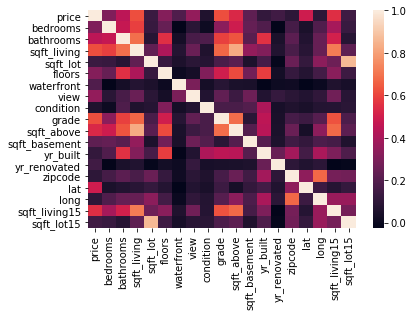

In [10]:

correlade.correlade.dcorr(clean_df, 1, 100)


AxesSubplot(0.125,0.125;0.62x0.755)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406
grade,0.667434,0.356967,0.664983,0.762704,0.113621,0.458183,0.082775,0.251321,-0.144674,1.000000,0.755923,0.168392,0.446963,0.014414,-0.184862,0.114084,0.198372,0.713202,0.119248


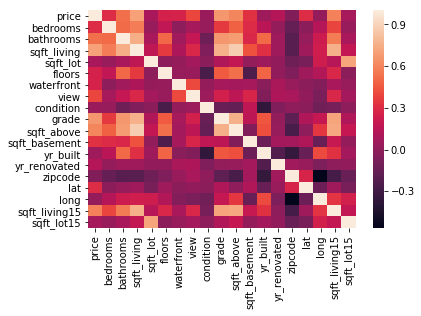

In [11]:
# Table and plot of correlations

# Drop non-numerical variables
# numerical = list(set(df.columns) - 
#                  set(['State', 'International plan', 'Voice mail plan', 
#                       'Area code', 'Churn', 'Customer service calls']))

# Calculate and plot
corr_matrix = clean_df.corr()
print(sns.heatmap(corr_matrix))

clean_df.corr()

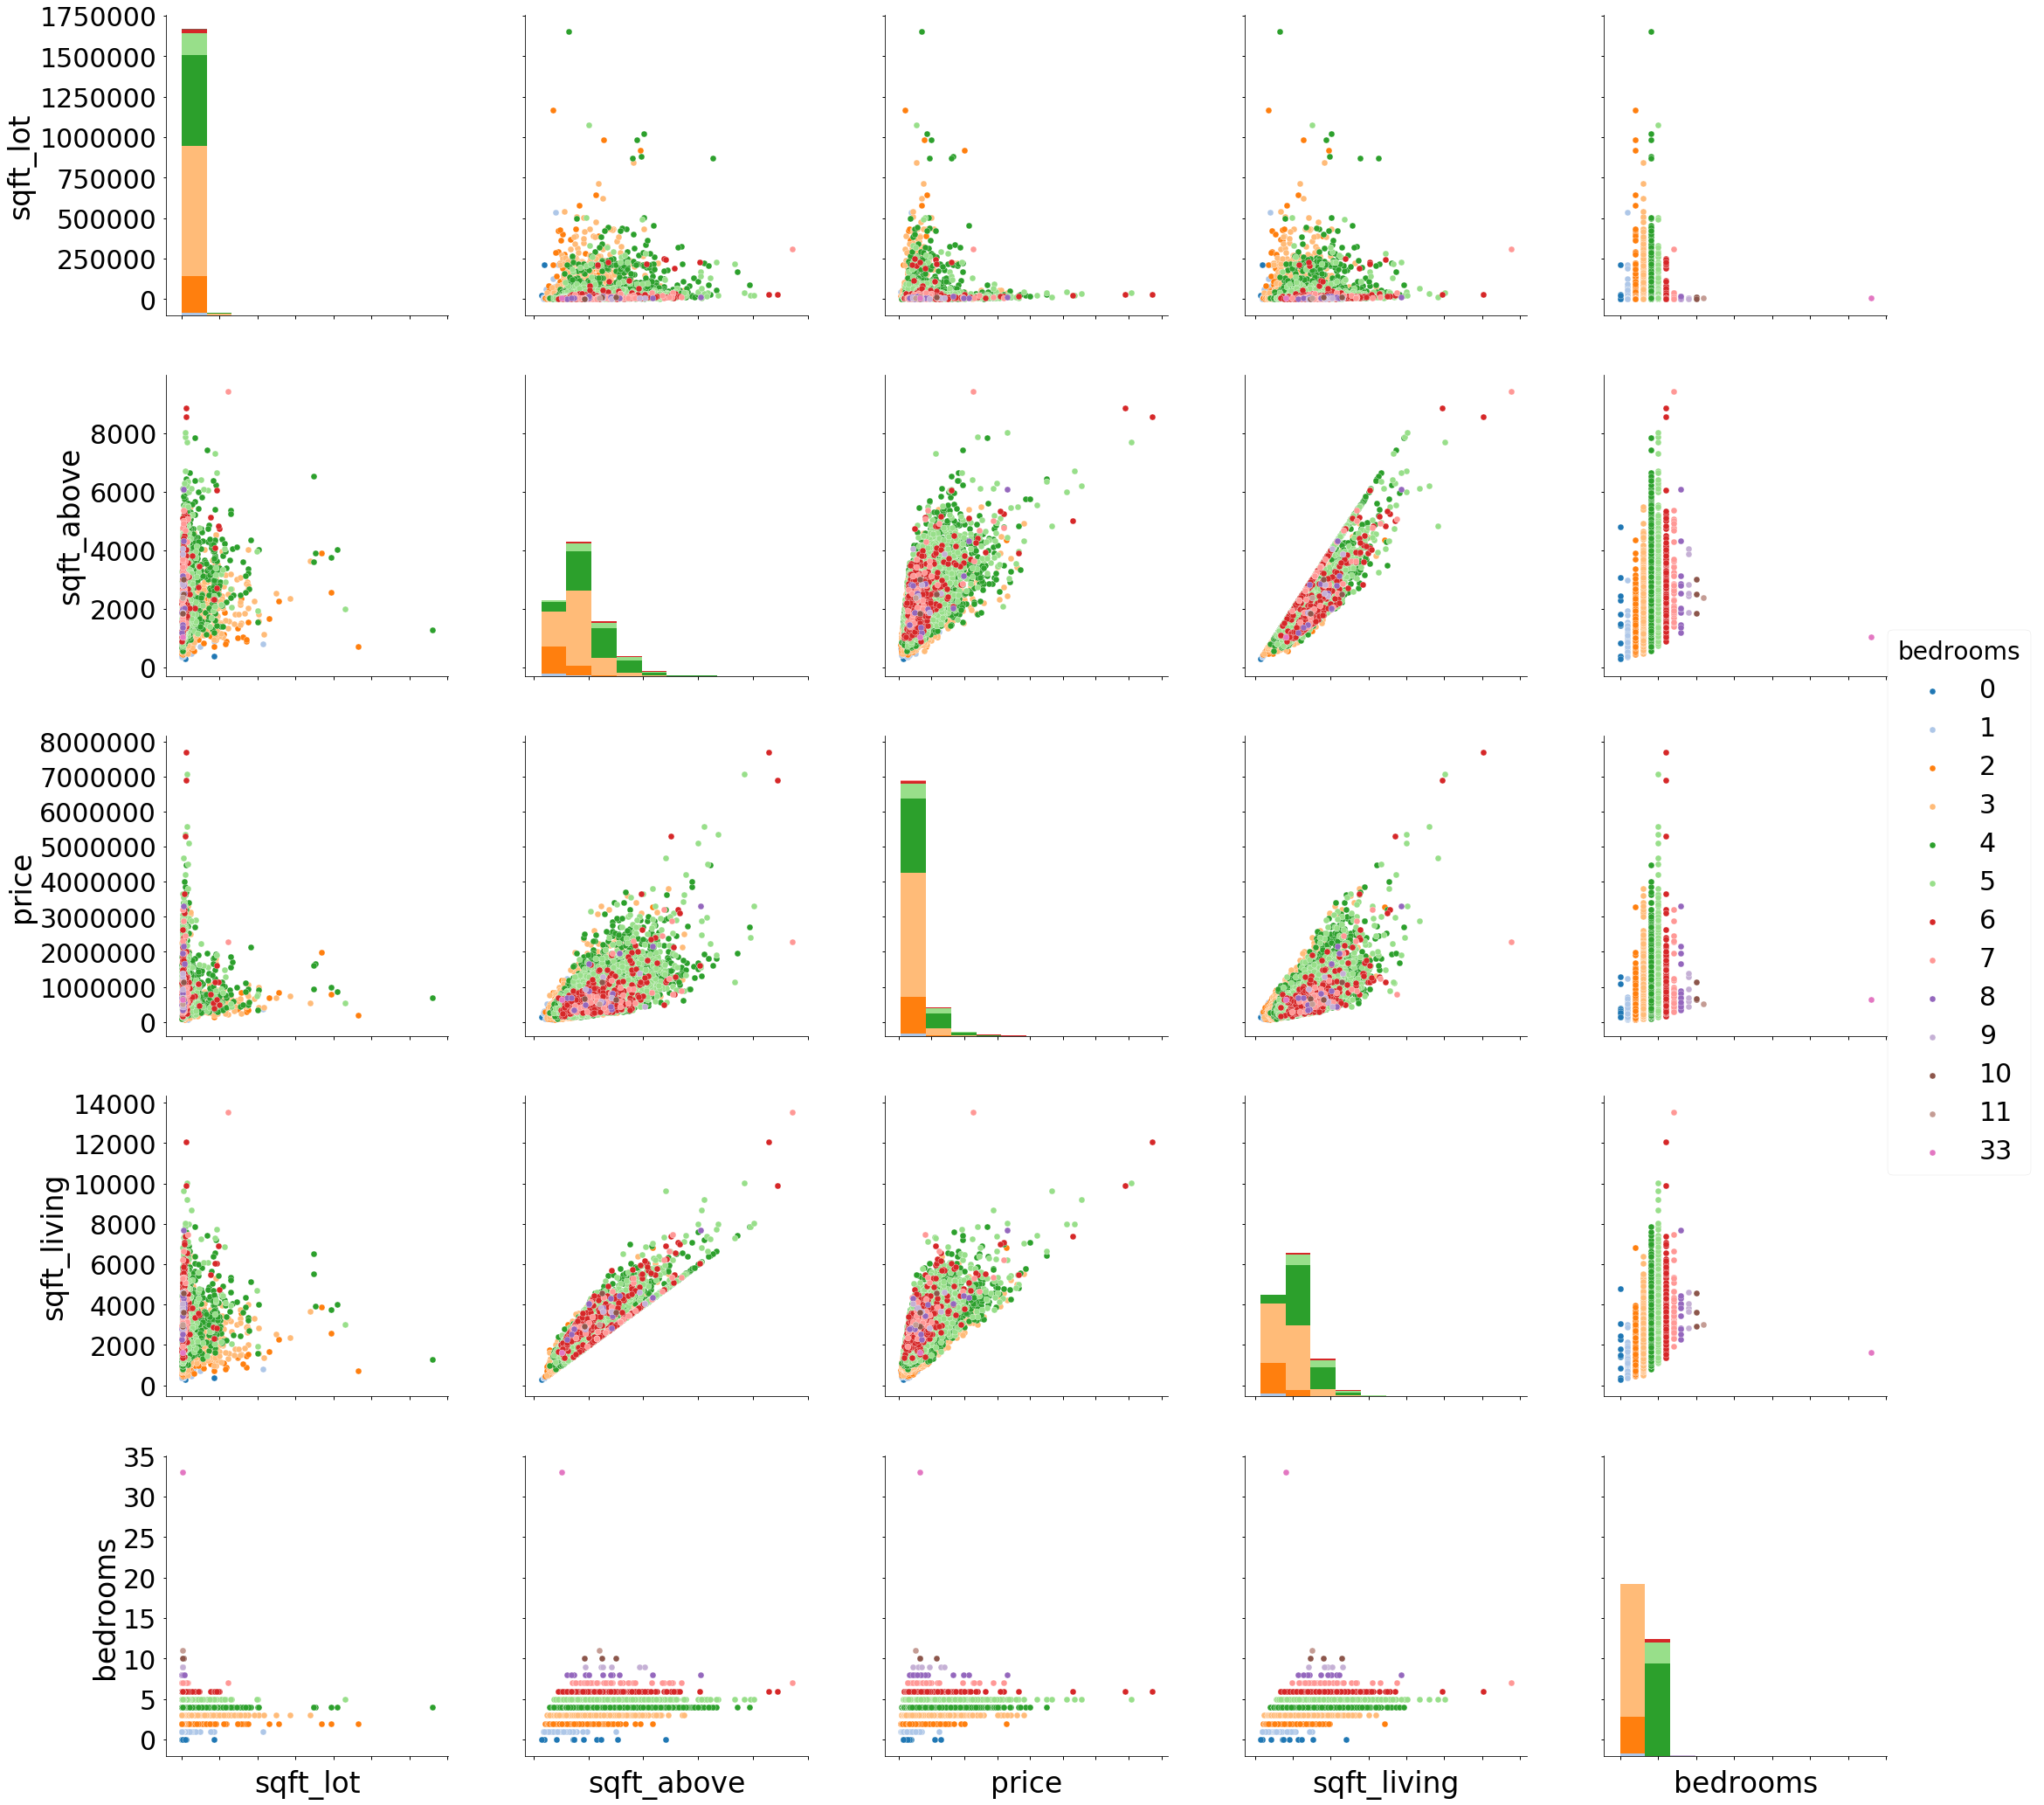

In [8]:
####################################################################################
# Section 2: Feature Engineering 
####################################################################################
with sns.plotting_context("notebook", font_scale = 3):
    graph = sns.pairplot(clean_df[['sqft_lot', 'sqft_above', 'price', 'sqft_living', 'bedrooms']], 
                 hue = 'bedrooms', palette = 'tab20', size = 6)
graph.set(xticklabels = []);

In [12]:
####################################################################################
# Section 3: Choose Features
####################################################################################

# Check feats with numerous zeros and cut the zeros to replot against price. If this makes it correlate consider
# making the feat a dichotomous var
# Do partial correlation coefficients to check if a var correlates with output-var when controlling for manually
# selected co-variates

features = clean_df.iloc[:,1:].columns.tolist()
target = clean_df.iloc[:,0].name

In [13]:
correlations = {}
for f in features:
    data_temp = clean_df[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [14]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


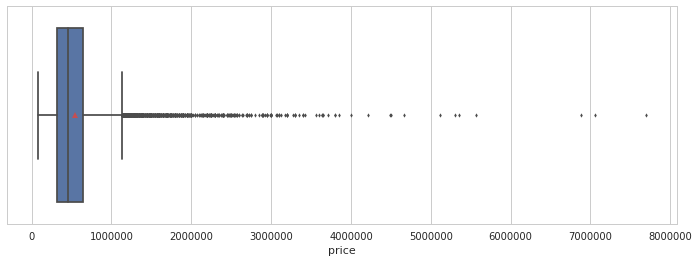

In [47]:
####################################################################################
# Section 3: Explore Output Var
####################################################################################

# Box Plot to assess outliers
fig, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x = 'price', data = clean_df, orient = 'h', width = 0.8, 
                 fliersize = 3, showmeans=True, ax = ax)
plt.show()
# Let's stick to within the whiskers ~ 1.1m

In [18]:
####################################################################################
# Section 4: LM Number 1
####################################################################################

# Which features correlate enough with target (What's the cut off? Is Pearson best measure? How about for categ) =
# Do the selected features correlate with eachother at all? What's the cutoff + best measure ==> VIF
# Measure of success with target
# Check for outliers
# EVALUATION:
# First check a plot of residuals --> Look for bias e.g residual higher in one section 
# Then r_squared? Learn how to interpret (Can't detect bias so must plot residuals)
# R_sq can be high for a bad model and vice versa, all relative to expectations
# Specification bias --> missing a polynmoial but still r_sq is good because it evens out
# R_sq with res_plot is good BUT DOESN'T Adjust for no. factors
# Therefore use adj_r_sq
# Too many predictors/ higher order polynomials and you're modelling noise +overfitting


lm = LinearRegression()

In [15]:
feats_round_1 = ['sqft_living', 'grade', 'bathrooms', 'lat']

x = clean_df[target]
y = clean_df[feats_round_1]

#Split into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y ,test_size=0.5)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [16]:
print('Training target: ', X_train.shape)
print('Training features: ', y_train.shape)
print('Validation target: ', X_val.shape)
print('Validation features: ', y_val.shape)
print('Testing target: ', X_test.shape)
print('Testing features: ', y_test.shape)


Training target:  (10806,)
Training features:  (10806, 4)
Validation target:  (5404,)
Validation features:  (5404, 4)
Testing target:  (5403,)
Testing features:  (5403, 4)


In [19]:
lm.fit(y_train, X_train)
print('Intercept: ', lm.intercept_)

Intercept:  -31565379.949679445


In [32]:
# Show coefficients
pd.DataFrame(list(zip(feats_round_1, lm.coef_)), columns = ['Features', 'Estimated-Coefficients'])

,Features,Estimated-Coefficients
0,sqft_living,201.498006
1,grade,93971.080915
2,bathrooms,-32094.614222
3,lat,652524.320457


In [37]:
# Evaluate LM with MSE
val_pred_lm_1 = lm.predict(y_val)
print("MSE: %.2f" % mean_squared_error(X_val, val_pred_lm_1))
print("R-squared: ", r2_score(X_val, val_pred_lm_1))

MSE: 53818507813.01
R-squared:  0.5932577033009208


In [18]:
"""
lm with ['sqft_living', 'grade', 'bathrooms'] non-normalised MSE: 56792806318.42
and r2 of 0.535 modelled on 50% and tested in val set 25%

"""

"\nlm with ['sqft_living', 'grade', 'bathrooms'] non-normalised MSE: 56792806318.42\nand r2 of 0.535 modelled on 50% and tested in val set 25%\n\n"

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406
grade,0.667434,0.356967,0.664983,0.762704,0.113621,0.458183,0.082775,0.251321,-0.144674,1.000000,0.755923,0.168392,0.446963,0.014414,-0.184862,0.114084,0.198372,0.713202,0.119248
